# TFY4345 Computational assignment 2
_Thorvald Molthe Ballestad_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from matplotlib import rc
# Set common figure parameters:
newparams = {'axes.labelsize': 11, 'axes.linewidth': 1, 'savefig.dpi': 300, 
             'lines.linewidth': 1.0, 'figure.figsize': (20, 10),
             'ytick.labelsize': 10, 'xtick.labelsize': 10,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,}
plt.rcParams.update(newparams)

We will investigate a simple pendulum limited to small oscillations, so that we have an harmonic oscillator.

In [3]:
# Setup
m = 1 #kg
R = 1 #m
g = 9.81 #m/s^2

theta_0 = 0.2 # rad, inital angle
omega_0 = 0.0 # rad/s, inital angular velocity
q = 1
F_D = 0.2

omega = np.sqrt(g/R)
omega_D = omega

end_time = 20 # s, the time at which the simulation will end
dt = 0.01

The problem consists of two first-order differential equations:
$$
\dot{\theta} = \omega\\
\dot{\omega} = \frac{F_{\perp}}{mR}.
$$

Let 
$$
y = 
\begin{bmatrix}
\theta\\
\omega
\end{bmatrix},
$$
then
$$
y' = 
\begin{bmatrix}
y_2\\
-\sin(y_1) / mR
\end{bmatrix}
= f(y).
$$

We will do the euler step:
$$
y(t+dt) = y(t) + f(y(t)) dt
$$

In [4]:
def f(y, t, q=0, F_D=0, omega_D=0, phi_D=0):
    """f(y) = y'
    b : damping factor"""
    return np.array([
                     y[1],
                   #-y[1]*q - g*np.sin(y[0])/R + F_D*np.sin(omega_D*t + phi_D)
                    -y[1]*q - g*y[0]/R + F_D*np.sin(omega_D*t + phi_D)
                    ])

In [5]:
def euler_step(y, f, t, dt, **kwargs):
    """Returns an euler-approximation of y(t+dt) given y(t) and t+dt"""
    return y + f(y, t, **kwargs)*dt

In [6]:
def rk4_solve(y, f, t, dt, **kwargs):
    """Runge-Kutta 4
    Parameters:
        y  : ndarray, with size (num_iterations, dim_of_problem), to fill with computed values.
             y[0] must be initial values
        f  : function that represents dy/dt
        dt : timestep to use
    Returns:
        y, with same size as input y, filled with solution"""
    g = lambda y: f(y, t, **kwargs)*dt
    
    
    for i, t in enumerate(t[:-1]):
        k_1 = g(y[i])
        k_2 = g(y[i] + k_1/2)
        k_3 = g(y[i] + k_2/2)
        k_4 = g(y[i] + k_3)
        y[i+1] = y[i] + (k_1 + 2*k_2 + 2*k_3 + k_4)/6
    return y

In [7]:
def kinetic_energy(omega):
    return 0.5*m*R**2*omega**2

def potential_energy(theta):
    return m*g*R*(1-np.cos(theta))

def total_energy(theta, omega):
    return kinetic_energy(omega) + potential_energy(theta)

def plt_method_energy(t, theta, omega, name):
    plt.plot(t, potential_energy(theta), label=f"{name} potential")
    plt.plot(t, kinetic_energy(theta), label=f"{name} kinetic")
    plt.plot(t, total_energy(theta, omega), label=f"{name} total")

In [8]:
def do_method(end_time, dt, solver=rk4_solve, theta_0=theta_0, omega_0=omega_0, **kwargs):
    """Use method given end_time, dt
    Returns:
     t: array of times
     y: 2D-array with [theta, omega]"""
    t = np.arange(0, end_time, dt)
    num_iterations = len(t)
    y = np.zeros((num_iterations, 2))
    y[0] = np.array([theta_0, omega_0])
    y = solver(y, f, t, dt, **kwargs)
    
    return t, y

def _get_coef(omega_D, q, F_D, omega):
    denominator = (omega**2-omega_D**2)**2 - q**2*omega_D**2
    
    A = F_D*q*omega_D/denominator
    B = F_D*(omega**2-omega_D**2)/denominator
    return A, B

def _analytical_self(t, theta_0=theta_0, q=0, omega=np.sqrt(g/R)):
    """Analytical solution to small-angle approx. (ie. harm. osc.)"""    
    omega_square = q**2/4-omega**2
    A,B = _get_coef(omega_D=omega_D, q=q, F_D=F_D, omega=omega)
    tan_phi = 2*(A-theta_0)*np.sqrt(omega**2-q**2/4) / (2*(B-omega_D)+q*(A-theta_0))
    
    if omega_square < 0:
        phi = np.arctan(tan_phi)
        amp = (theta_0 - A)/np.sin(phi)
        return amp*np.exp(-q*t/2)*np.sin(np.sqrt(-omega_square)*t+phi)
    if omega_square > 0:
        B = 1/2 - q/(4*np.sqrt(omega_square))
        A = 1 - B
        return theta_0*np.exp(-q*t/2)*(A*np.exp(np.sqrt(omega_square)*t) + B*np.exp(-np.sqrt(omega_square)*t))
    return theta_0*(1+q*t/2)*np.exp(-q*t/2)

def _drive(t, F_D=0, omega_D=0, phi_D=0, q=q, omega=0):
    A,B = _get_coef(omega_D=omega_D, q=q, F_D=F_D, omega=omega)
    
    return A*np.cos(omega_D*t) + B*np.sin(omega_D*t)

def analytical(t, theta_0=theta_0, q=0, F_D=0, omega_D=0, phi_D=0):
    omega = np.sqrt(g/R)
    return _analytical_self(t, theta_0=theta_0, q=q) + _drive(t, F_D=F_D, omega_D=omega_D, phi_D=phi_D, q=q, omega=omega)

"""
def analytical(t, theta_0=theta_0, q=0, F_D=0, omega_D=0, phi_D=0):
    omega=np.sqrt(g/R)
    tan_phi = np.sqrt(omega**2*4/q**2-1) / (1-2*F_D/(q*omega_D*theta_0))
    phi = np.arctan(tan_phi)
    A = theta_0/np.sin(phi)
    return A*np.exp(-q*t/2)*np.sin(np.sqrt(omega**2-q**2/4)*t + phi) + F_D*np.sin(omega_D*t)/omega_D**2
    """

'\ndef analytical(t, theta_0=theta_0, q=0, F_D=0, omega_D=0, phi_D=0):\n    omega=np.sqrt(g/R)\n    tan_phi = np.sqrt(omega**2*4/q**2-1) / (1-2*F_D/(q*omega_D*theta_0))\n    phi = np.arctan(tan_phi)\n    A = theta_0/np.sin(phi)\n    return A*np.exp(-q*t/2)*np.sin(np.sqrt(omega**2-q**2/4)*t + phi) + F_D*np.sin(omega_D*t)/omega_D**2\n    '

In [9]:
def _get_coef(omega_D=omega_D, q=q, F_D=F_D, omega=omega):
    denominator = (omega**2-omega_D**2)**2 - q**2*omega_D**2
    
    A = F_D*q*omega_D/denominator
    B = F_D*(omega**2-omega_D**2)/denominator
    return A, B

def _drive(t, F_D=F_D, omega_D=0, phi_D=0, q=q, omega=omega):
    A,B = _get_coef(omega_D=omega_D, q=q, F_D=F_D, omega=omega)
    return A*np.cos(omega_D*t) + B*np.sin(omega_D*t)

def _hom(t, theta_0=theta_0, q=1, omega=omega, omega_D=omega_D):
    A_p, B_p = _get_coef(omega_D=omega_D, q=q, F_D=F_D, omega=omega)
    eps = np.lib.scimath.sqrt(q**2/4-omega**2)
    
    B = (B_p*omega_D+ + (eps-q/2)*(theta_0-A_p)) / (2*eps)
    A = theta_0 - A_p - B
    
    return np.exp(-q*t/2) * (A*np.exp(eps*t)+B*np.exp(-eps*t))

def analytical(t, theta_0=theta_0, q=0, F_D=0, omega_D=0, phi_D=0, omega=omega):
    return _drive(t, F_D=F_D, omega_D=omega_D, phi_D=phi_D, q=q, omega=omega) + _hom(t, theta_0=theta_0, q=q, omega=omega, omega_D=omega_D)

# Part 1
## Overdamped, critically damped, and underdamped

/usr/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


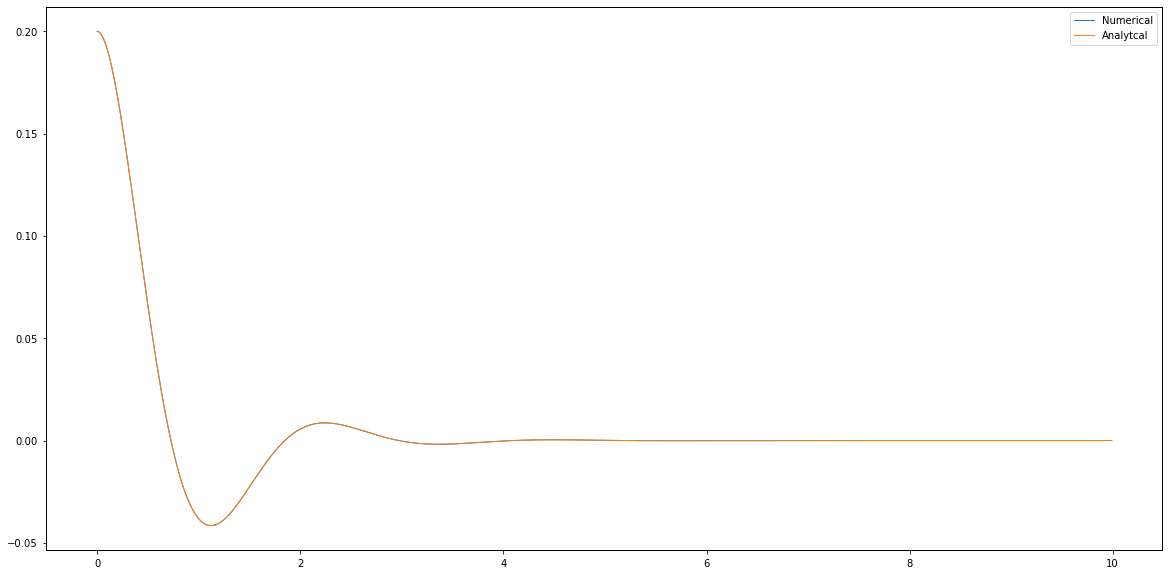

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in add


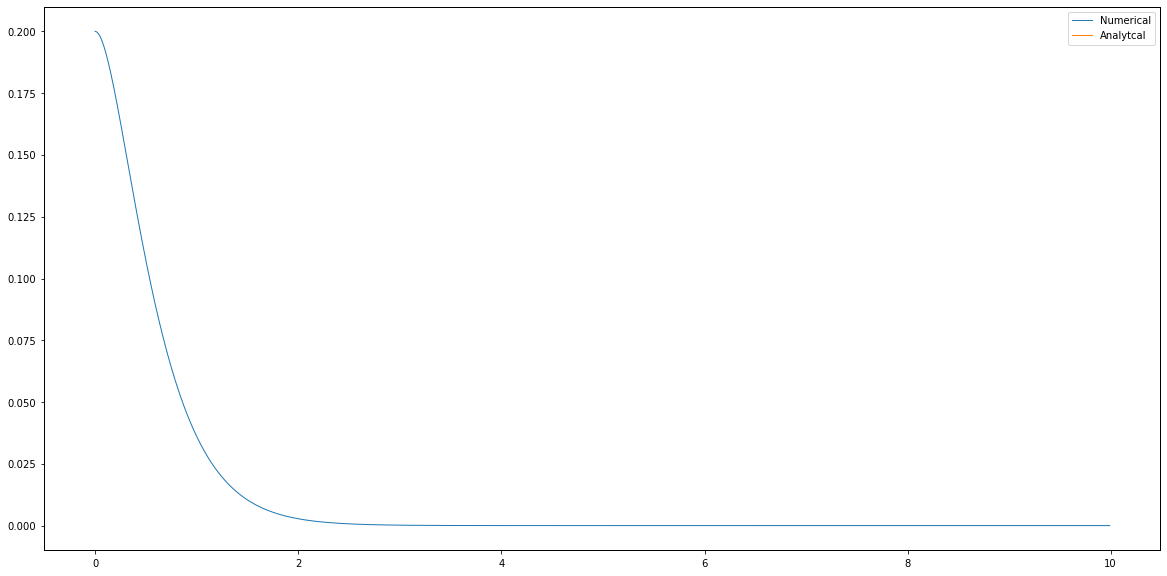

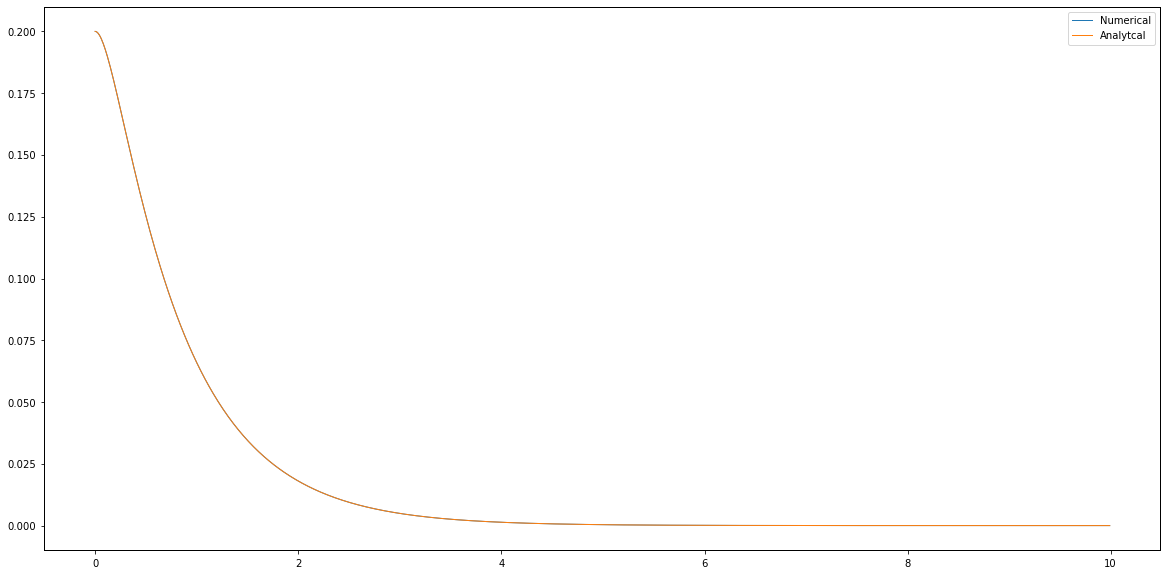

In [10]:
damping_factors = np.sqrt(4*m*g/R * np.array([0.2, 1, 2]))
for q_val in damping_factors:
    t, y = do_method(10, dt, q=q_val, F_D=0)
    plt.plot(t, y[:,0], label="Numerical")
    plt.plot(t, analytical(t, q=q_val), label="Analytcal")
    plt.legend()
    plt.show()

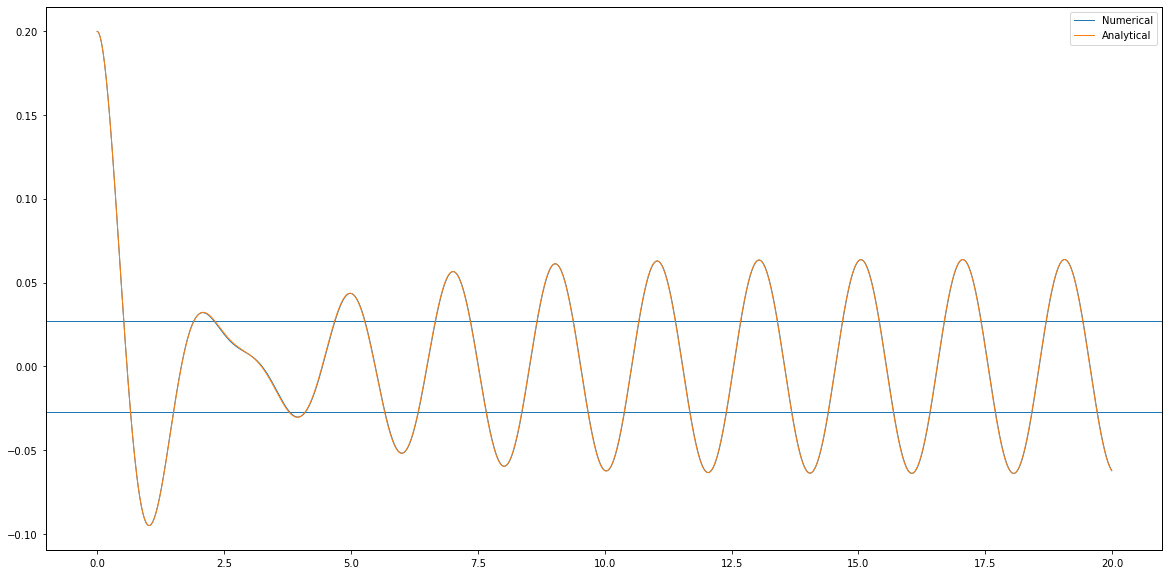

In [11]:
t,y = do_method(end_time, dt, solver=rk4_solve, q=q, F_D=F_D, omega_D=omega_D)
plt.plot(t, y[:,0], label="Numerical")
ss = F_D/np.sqrt((omega**2-omega_D)**2+(q*omega_D)**2)
plt.axhline(ss)
plt.axhline(-ss)
plt.plot(t, analytical(t, q=q, F_D=F_D, omega_D=omega_D), label="Analytical")
plt.legend()